In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
import pandas as pd
from typing import List
import torchvision

import torch.nn.functional as F
import pytorch_lightning as pl

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '..'))

from symlie.data.transforms import TransformRefactored


from symlie.run import parse_options, main, process_args


In [2]:
args = parse_options(notebook=True)

args.noise_std = 1.
args.grid_size = (1, 7)
args.eps_mult = [0.0, 0.0, 1.0, 0.0]
args.net = 'TrainP'
args.data_dir = '../data/sine1d'
args.y_low = 1
args.y_high = 3
args.noise_std = 0.5

args.do_return = True
args.logger = None

args.n_train = 100

process_args(args)

# Training
_, _, datamodule = main(args)

n_epochs = 50
size = np.prod(args.grid_size)

Seed set to 42


Running without logging


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [3]:
trainloader = datamodule.train_dataloader()

In [4]:
class TransformationBlock(TransformRefactored):
    def __init__(self, transform_kwargs):
        TransformRefactored.__init__(self, eps_mult = transform_kwargs['eps_mult'])

    def forward_transformation(self, batch_size, shape, weight):

        if type(shape) == tuple:
            shape = {'a':shape, 'b':shape}

        eps = torch.randn((4,))
        
        x_a = x_b = torch.randn((batch_size, np.prod(shape['b'])))

        # Route a: Forward pass, transformation
        out_a = F.linear(x_a, weight)
        out_a_prime = self.transform(out_a, eps, shape=shape['a'])

        # Route b: Transformation, forward pass
        x_b_prime = self.transform(x_b, eps, shape=shape['b'])
        out_b_prime = F.linear(x_b_prime, weight)

        assert out_a_prime.shape == out_b_prime.shape

        return (out_a_prime, out_b_prime)

transform = TransformationBlock(args.transform_kwargs)

In [5]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def __repr__(self):
        return f'View{self.shape}'

    def forward(self, x):
        '''
        Reshapes the input x according to the shape saved in the view data structure.
        '''
        out = x.reshape(*self.shape)
        return out

class PredictionLearner(nn.Module):
    def __init__(
            self,
            size: int,
            implicit_layer_dims: List[List[int]],
            vanilla_layer_dims: List[int],
        ):
        super().__init__()
        self.size = size

        self.weight2 = nn.Parameter(torch.rand(vanilla_layer_dims[1], vanilla_layer_dims[2]).T)


        implicit_layer_dim = implicit_layer_dims[0]
        vanilla_layer_dim = vanilla_layer_dims[0]
        layer_idx = 0

        in_features, out_features = vanilla_layer_dim, vanilla_layer_dims[layer_idx+1]

        n_features = in_features * out_features
        assert n_features == implicit_layer_dim[0],  f"n_features: {n_features}, implicit_layer_dim[0]: {implicit_layer_dim[0]}"
        assert n_features == implicit_layer_dim[-1], f"n_features: {n_features}, implicit_layer_dim[-1]: {implicit_layer_dim[-1]}"

        self.layers1 = nn.Sequential(
            View((n_features,)),
            torchvision.ops.MLP(in_channels=implicit_layer_dim[0], hidden_channels=implicit_layer_dim[1:]),
            View((out_features, in_features)), 
        ) 
        self.weight1 = nn.Parameter(torch.randn(out_features, in_features)) 

        # self.layers = nn.ParameterList()
        # self.weights = nn.ParameterList()
        # self.weights_out = []
        # for layer_idx, (implicit_layer_dim, vanilla_layer_dim) in enumerate(zip(implicit_layer_dims, vanilla_layer_dims)):
        #     in_features, out_features = vanilla_layer_dim, vanilla_layer_dims[layer_idx+1]

        #     if implicit_layer_dim == [0]:
        #         layer = nn.Identity() 
        #     else: 
        #         n_features = in_features * out_features
        #         assert n_features == implicit_layer_dim[0],  f"n_features: {n_features}, implicit_layer_dim[0]: {implicit_layer_dim[0]}"
        #         assert n_features == implicit_layer_dim[-1], f"n_features: {n_features}, implicit_layer_dim[-1]: {implicit_layer_dim[-1]}"

        #         layer = nn.Sequential(
        #             View((n_features,)),
        #             torchvision.ops.MLP(in_channels=implicit_layer_dim[0], hidden_channels=implicit_layer_dim[1:]),
        #             View((out_features, in_features)), 
        #         ) 
        #     self.layers.append(layer)
        #     self.weights.append( nn.Parameter(torch.randn(out_features, in_features)) )

        # self.layers1 = self.layers[0]
        # self.weight1 = self.weights[0]


        
        self.activation = nn.ReLU()

    def mlp1(self, weight, layers):
        weight = weight.reshape(self.size**2)
        weight = layers(weight)
        weight = weight.reshape(self.size, self.size)
        return weight
    

    # def forward(self, x):
        

    #     weight = self.layers[0](self.weights[0])
    #     self.weights_out.append(weight)
    #     x = F.linear(x, weight)

    #     x = self.activation(x)

    #     # weight = self.layers[1](self.weights[1])
    #     weight = self.weights[1]
    #     x = F.linear(x, weight)

    #     # weight = self.weight2
    #     # x = F.linear(x, weight)
        
    #     return x

    def forward(self, x):
        

        weight = self.mlp1(self.weight1,self.layers1)
        x = F.linear(x, weight)

        x = self.activation(x)

        weight = self.weight2
        x = F.linear(x, weight)
        
        return x
    
    
class CombiMLP(torch.nn.Module):
    def __init__(self, 
            implicit_layer_dims: List[List[int]],
            vanilla_layer_dims: List[int],
            bias: bool,
            activation = torch.nn.ReLU,
        ):
        super().__init__()
        
        assert bias == False, 'Not implemented'
        assert len(implicit_layer_dims) == len(vanilla_layer_dims)-1

        self.activation = activation()

        self.layers = nn.ParameterList()
        self.weights = nn.ParameterList()
        self.weights_out = []
        for layer_idx, (implicit_layer_dim, vanilla_layer_dim) in enumerate(zip(implicit_layer_dims, vanilla_layer_dims)):
            in_features, out_features = vanilla_layer_dim, vanilla_layer_dims[layer_idx+1]

            if implicit_layer_dim == [0]:
                layer = nn.Identity() 
            else: 
                n_features = in_features * out_features
                assert n_features == implicit_layer_dim[0],  f"n_features: {n_features}, implicit_layer_dim[0]: {implicit_layer_dim[0]}"
                assert n_features == implicit_layer_dim[-1], f"n_features: {n_features}, implicit_layer_dim[-1]: {implicit_layer_dim[-1]}"

                layer = nn.Sequential(
                    View((n_features,)),
                    torchvision.ops.MLP(in_channels=implicit_layer_dim[0], hidden_channels=implicit_layer_dim[1:]),
                    View((out_features, in_features)), 
                ) 
            self.layers.append(layer)
            self.weights.append( nn.Parameter(torch.randn(out_features, in_features)) )

        
        

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:

        outs = [x]

        for layer_idx, (layer, weight) in enumerate(zip(self.layers, self.weights)):
            weight_out = layer(weight)
            self.weights_out.append(weight_out)

            x = F.linear(x, weight_out)

            
            if layer_idx != len(self.layers)-1:
                x = self.activation(x)

            outs.append(x)

        return x

In [6]:

seed, method = 41, 'mlp'

# Initialize the MLP
net1 = PredictionLearner(
    size=size, 
    implicit_layer_dims=[[49, 49, 49], [0]],
    vanilla_layer_dims=[7, 7, 1],
)
net2 = CombiMLP(
    implicit_layer_dims=[[49, 49, 49], [7,7]],
    vanilla_layer_dims=[7, 7, 1],
    bias = False,
)

net_id = 1
if net_id == 1:
    net = net1
else:
    net = net2


# Define the loss function and optimizer
criterion_y     = nn.MSELoss()
criterion_o     = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

losses_y = []
losses_o = []

# Run the training loop
for epoch in tqdm(range(0, n_epochs), desc = f'seed={seed}, method={method}'):
    
    current_loss_y = 0.0
    current_loss_o = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        # Get inputs
        x, y, _ = data
        batch_size = x.size(0)
        
        
        # Zero the gradients
        optimizer.zero_grad()

        y_pred = net(x)
        
        if net_id == 1:
            weight = net.mlp1(net.weight1, net.layers1)
            # weight = net.layers[0](net.weights[0])
            # weight = net.weights_out[0].detach()
        else:
            weight = net.weights_out[0]
        
        o_a_prime, o_b_prime = transform.forward_transformation(batch_size, (1, 7), weight)


        # Compute loss
        loss_o = criterion_o(o_a_prime, o_b_prime)

        # Compute loss
        loss_y = criterion_y(y_pred, y)

        loss = loss_o + loss_y

        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss_y += loss_o.item()
        current_loss_o += loss_y.item()
    current_loss_y = current_loss_y / len(trainloader)
    current_loss_o = current_loss_o / len(trainloader)
    losses_y.append(current_loss_y)
    losses_o.append(current_loss_o)



seed=41, method=mlp: 100%|██████████| 50/50 [00:03<00:00, 12.57it/s]


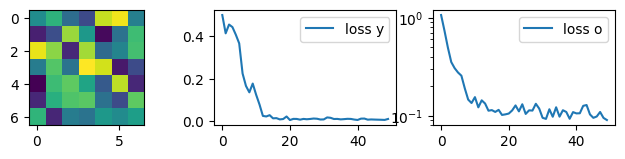

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(8,1.5))

weight = torch.rand(size, size)
weight = net.mlp1(weight, net.layers1)
    # weight = net.layers[0](net.weights[0])

ax = axs[0]
ax.imshow( weight.detach().cpu().numpy() )

ax = axs[1]
ax.plot(losses_y, label='loss y')
ax.legend()

ax = axs[2]
ax.plot(losses_o, label='loss o')
ax.set_yscale('log')
ax.legend()

plt.show()

